In [18]:
import function as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import os
import seaborn as sns

In [19]:
folder_path = 'Results'
y_col = ['C_max_prev', 'C_max_now', 'C_max', 'Congestion_ratio_AVG', 'Congestion_ratio_AVG_prev', 'Congestion_ratio_AVG_now']

original_df = f.get_dfs_by_folder(folder_path, y_col, True, standard_outlier = y_col[2])

original_df = f.to_numeric(original_df, y_col[0])
original_df = f.to_numeric(original_df, y_col[1])
original_df = f.to_numeric(original_df, y_col[3])
original_df_30s = f.to_numeric(original_df, y_col[4])
original_df = f.to_numeric(original_df, y_col[5])

for file_name, df in original_df:
    # add column
    df['Number of YT'] = int(df['Prev Truck Number'].unique()[0]) + int(df['Now Truck Number'].unique()[0])

all_alpha_df = pd.DataFrame()

# original_df에 있는 모든 파일을 합쳐 하나의 df로 만들기
for file_name, df in original_df:
    all_alpha_df = pd.concat([all_alpha_df, df], ignore_index=True)

all_alpha_df

Remove outliers by  C_max !


,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,repeat_num,C_max_prev,C_max_now,C_max,Congestion_ratio_AVG,Congestion_ratio_AVG_prev,Congestion_ratio_AVG_now,Number of YT
0,5,5,0,0,100,1,404.816,396.952,404.816,0.036557,0.034676,0.038438,10
1,5,5,0,0,100,2,430.392,389.856,430.392,0.031613,0.046885,0.016342,10
2,5,5,0,0,100,3,395.136,403.208,403.208,0.047560,0.038560,0.056561,10
3,5,5,0,0,100,4,379.360,406.512,406.512,0.076458,0.058949,0.093967,10
4,5,5,0,0,100,5,367.512,419.168,419.168,0.023216,-0.013357,0.059789,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5753,30,30,80,10,10,56,441.536,448.848,448.848,0.286701,0.330823,0.242578,60
5754,30,30,80,10,10,57,429.856,444.728,444.728,0.332213,0.238609,0.425816,60
5755,30,30,80,10,10,58,433.640,446.616,446.616,0.371354,0.450646,0.292061,60
5756,30,30,80,10,10,59,451.176,440.272,451.176,0.260300,0.284196,0.236405,60


In [20]:
df  = all_alpha_df.copy()

# 'Number of YT'에 따라 데이터 분리하고, 'alpha_1', 'alpha_2', 'alpha_3'의 값이 같은 행끼리 묶은 뒤, 'Congestion_ratio_AVG'의 평균 계산
congestion_ratio_avg = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['Congestion_ratio_AVG'].mean().reset_index()

C_max_avg = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max'].mean().reset_index()
C_max_prev_avg = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max_prev'].mean().reset_index()
C_max_now_avg = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max_now'].mean().reset_index()

# 결과 출력
C_max_avg

,Number of YT,alpha_1,alpha_2,alpha_3,C_max
0,10,0,0,100,407.322621
1,10,10,80,10,411.559714
2,10,20,70,10,409.148000
3,10,30,60,10,409.195649
4,10,40,50,10,409.341614
...,...,...,...,...,...
94,60,40,50,10,457.241846
95,60,50,40,10,453.213647
96,60,60,30,10,462.663709
97,60,70,20,10,459.559852


c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


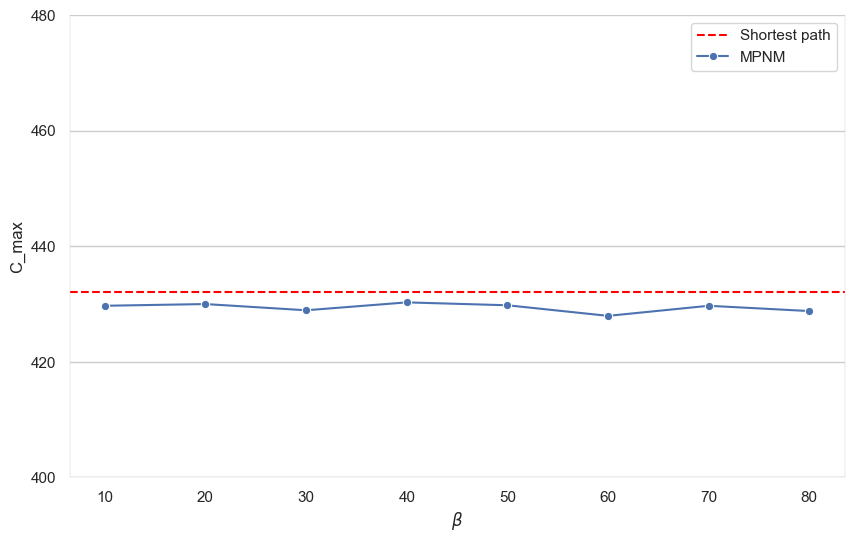

In [21]:
C_max_df_40s = pd.DataFrame(C_max_avg[(C_max_avg['Number of YT'] == 40)])
C_max_df_60s = pd.DataFrame(C_max_avg[(C_max_avg['Number of YT'] == 60)])

# C_max_df_40s


# Separate data for alpha_2=0, 0, 100 and other values
C_max_df_40s_ref = C_max_df_40s[C_max_df_40s['alpha_2'] == 0]
C_max_df_40s_other = C_max_df_40s[C_max_df_40s['alpha_2'] != 0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal reference line for alpha (0, 0, 100)
plt.axhline(y=C_max_df_40s_ref['C_max'].iloc[0], color='red', linestyle='--', label='Shortest path')

# Plotting other alpha values with viridis color map
sns.lineplot(x='alpha_2', y='C_max', data=C_max_df_40s_other, marker='o', linestyle='-', label='MPNM', ax=ax, palette='viridis')

# Adding labels and title
plt.xlabel(r"$\beta$")
plt.ylabel('C_max')
# plt.title('Average of C_max for 40 YTs')
plt.yticks(np.arange(400, 500, 20))

# Adding grid and legend
plt.grid(True)
plt.legend()

# Setting spine widths
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0.3)
ax.spines['left'].set_linewidth(0.3)
ax.xaxis.grid(False)

# Display the plot
plt.show()


c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  if sys.path[0] == "":


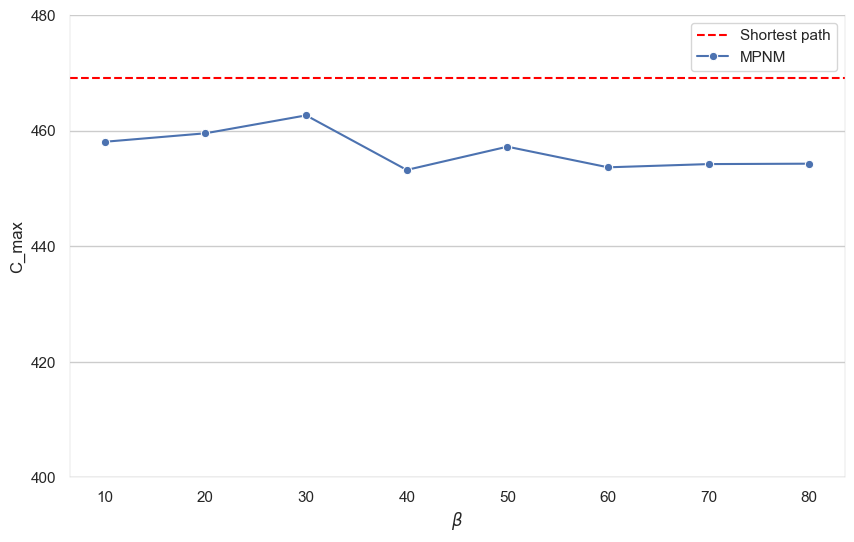

In [22]:
# Separate data for alpha_2=0, 0, 100 and other values
C_max_df_60s_ref = C_max_df_60s[C_max_df_60s['alpha_2'] == 0]
C_max_df_60s_other = C_max_df_60s[C_max_df_60s['alpha_2'] != 0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal reference line for alpha (0, 0, 100)
plt.axhline(y=C_max_df_60s_ref['C_max'].iloc[0], color='red', linestyle='--', label='Shortest path')

# Plotting other alpha values with viridis color map
sns.lineplot(x='alpha_2', y='C_max', data=C_max_df_60s_other, marker='o', linestyle='-', label='MPNM', ax=ax, palette='viridis')

# Adding labels and title
plt.xlabel(r"$\beta$")
plt.ylabel('C_max')
# plt.title('Average of C_max for 60 YTs')
plt.yticks(np.arange(400, 500, 20))

# Adding grid and legend
plt.grid(True)
plt.legend()

# Setting spine widths
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0.3)
ax.spines['left'].set_linewidth(0.3)
ax.xaxis.grid(False)

# Display the plot
plt.show()

In [23]:
# Extract reference C_max for alpha_1=0, alpha_2=0, alpha_3=100
reference_C_max = C_max_df_60s.loc[(C_max_df_60s['alpha_1'] == 0) & (C_max_df_60s['alpha_2'] == 0) & (C_max_df_60s['alpha_3'] == 100), 'C_max'].values[0]

# Calculate Percentage Decrease for each row
C_max_df_60s['Percentage_Decrease'] = ((C_max_df_60s['C_max'] - reference_C_max) / reference_C_max) * 100
C_max_df_60s['Percentage_Decrease']
# # Plotting the Percentage Decrease based on alpha_2 values
# plt.plot(C_max_df_40s['alpha_2'], C_max_df_40s['Percentage_Decrease'], marker='o', linestyle='-', label='Percentage Decrease')

# # Adding labels and title
# plt.xlabel('alpha_2')
# plt.ylabel('Percentage Decrease')
# plt.title('Percentage Decrease vs. alpha_2')

# # Adding grid and legend
# plt.grid(True)
# plt.legend()

# # Display the plot
# plt.show()

90    0.000000
91   -3.153321
92   -3.168012
93   -3.287133
94   -2.525507
95   -3.384236
96   -1.369678
97   -2.031356
98   -2.344317
Name: Percentage_Decrease, dtype: float64

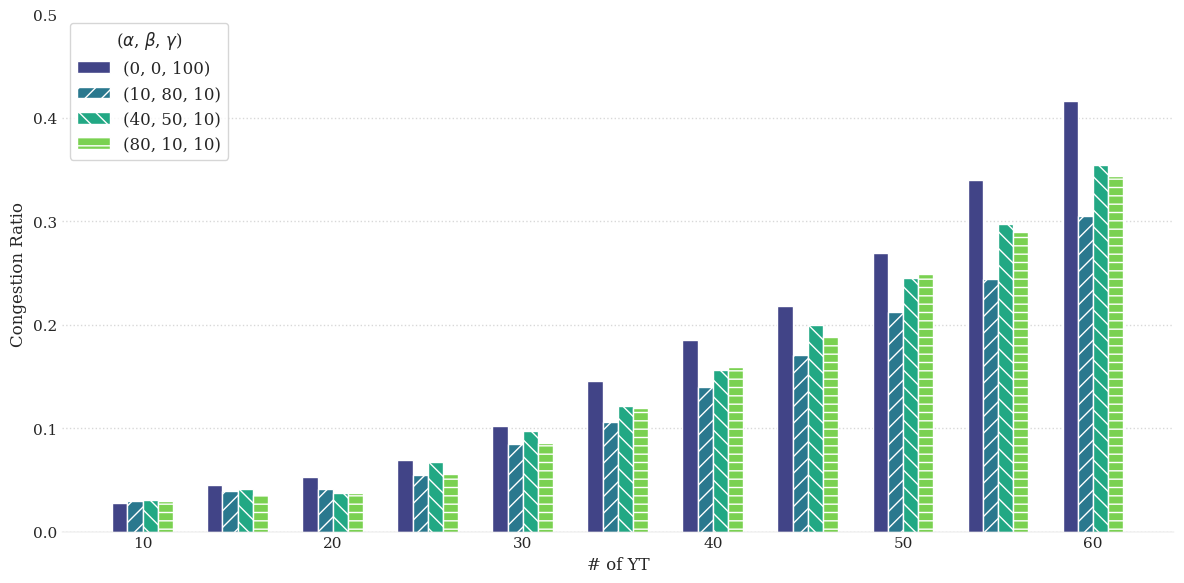

In [24]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font style to a more suitable one for academic writing
plt.rcParams['font.family'] = 'serif'

# Copy the DataFrame
df = congestion_ratio_avg.copy()

# Define alpha values
alpha_values = [[0, 10, 40, 80],
                [0, 80, 50, 10],
                [100, 10, 10, 10]]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 6))

# Use seaborn's color palette
colors = sns.color_palette("viridis", n_colors=len(alpha_values[0]))

# Define hatch patterns
hatch_patterns = ['', '//', '\\\\', '--']

# Set the width of each bar
bar_width = 0.8

# Loop through alpha values and plot each set of bars
for i, (alpha_1, alpha_2, alpha_3) in enumerate(zip(*alpha_values)):
    # Filter rows based on the current alpha values
    filtered_df = df[(df['alpha_1'] == alpha_1) & (df['alpha_2'] == alpha_2) & (df['alpha_3'] == alpha_3)]
    
    # Calculate the x-axis positions for each bar
    x_positions = filtered_df['Number of YT'] + (i - (len(alpha_values[0]) - 1) / 2) * bar_width
    
    # Plot the bar for the current alpha combination with hatch pattern
    ax.bar(x_positions, filtered_df['Congestion_ratio_AVG'],
           width=bar_width, label=f'({alpha_1}, {alpha_2}, {alpha_3})', color=colors[i], hatch=hatch_patterns[i])

# Set labels and title
ax.set_xlabel('# of YT', fontweight='ultralight')
ax.set_ylabel('Congestion Ratio', fontweight='ultralight')
# ax.set_title('Congestion Ratio with Different Weights')

# Set y-axis ticks in increments of 0.1
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 0.5)

# Remove both x and y axis ticks
ax.tick_params(axis='both', which='both', length=0)

# Remove vertical grid lines
ax.xaxis.grid(False)

# Customize y-axis grid lines
ax.yaxis.grid(True, color='gray', linestyle='dotted', alpha=0.3)

# Customize legend font size
ax.legend(title=r"($\alpha$, $\beta$, $\gamma$)", prop={'size': 12})

# Set thinner border lines
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)

# Remove y-axis grid line at y=0.5
yticks = ax.get_yticks()
ygridlines = ax.get_ygridlines()
for ytick, ygridline in zip(yticks, ygridlines):
    if ytick == 0.5:
        ygridline.set_visible(False)
 
# Show the plot
plt.tight_layout()
plt.show()


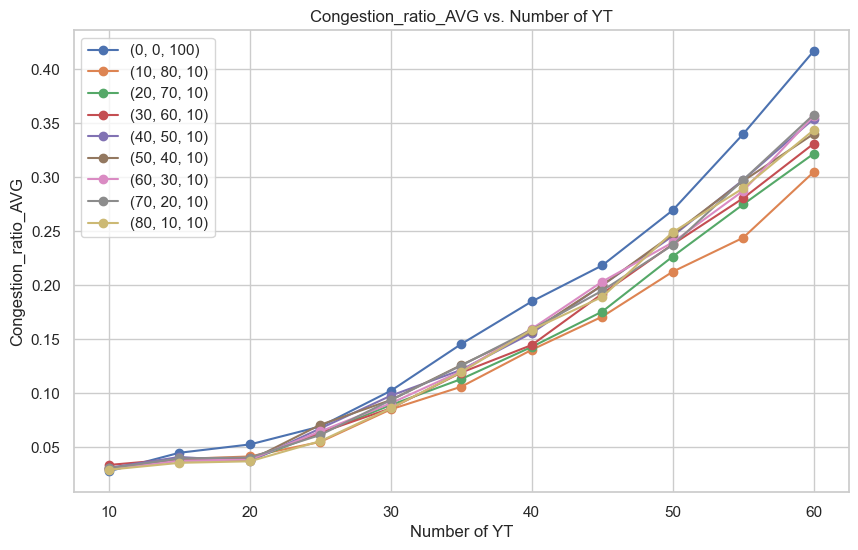

In [25]:
# 특정 알파값에 따라 데이터 추출 및 그래프 그리기
alpha_values = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
                [0, 80, 70, 60, 50, 40, 30, 20, 10],
                [100, 10, 10, 10, 10, 10, 10, 10, 10]]

# 전체 그래프를 그리기 위한 설정
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# 각 알파값에 따라 데이터를 추출하고 그래프 그리기
for i in range(len(alpha_values[0])):
    df = congestion_ratio_avg.copy()
    df = df[(df['alpha_1'] == alpha_values[0][i]) & (df['alpha_2'] == alpha_values[1][i]) & (df['alpha_3'] == alpha_values[2][i])]
    
    # 꺾은선 그래프 그리기
    plt.plot(df['Number of YT'], df['Congestion_ratio_AVG'], marker='o', linestyle='-', label=f'({alpha_values[0][i]}, {alpha_values[1][i]}, {alpha_values[2][i]})')

# 그래프에 레이블 추가
plt.xlabel('Number of YT')
plt.ylabel('Congestion_ratio_AVG')
plt.title('Congestion_ratio_AVG vs. Number of YT')

# 그리드 추가
plt.grid(True)

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()

In [26]:
df_40s = pd.DataFrame(congestion_ratio_avg[(congestion_ratio_avg['Number of YT'] == 40)])
df_60s = pd.DataFrame(congestion_ratio_avg[(congestion_ratio_avg['Number of YT'] == 60)])

df_40s
# print(df_60s['Congestion_ratio_AVG'])

,Number of YT,alpha_1,alpha_2,alpha_3,Congestion_ratio_AVG
54,40,0,0,100,0.184997
55,40,10,80,10,0.140230
56,40,20,70,10,0.142909
57,40,30,60,10,0.144637
58,40,40,50,10,0.155796
59,40,50,40,10,0.157371
60,40,60,30,10,0.159659
61,40,70,20,10,0.158979
62,40,80,10,10,0.158733


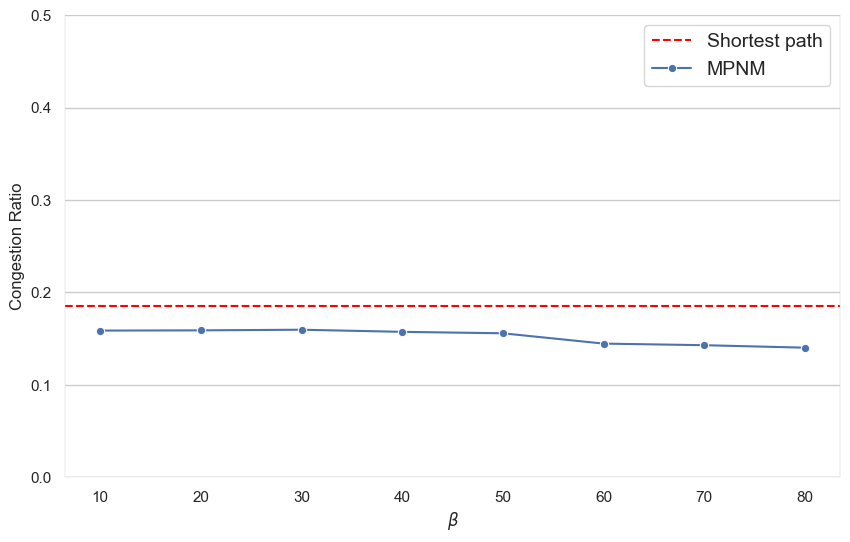

In [27]:
# Separate data for alpha_2=0, 0, 100 and other values
df_40s_ref = df_40s[df_40s['alpha_2'] == 0]
df_40s_other = df_40s[df_40s['alpha_2'] != 0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal reference line for alpha (0, 0, 100)
plt.axhline(y=df_40s_ref['Congestion_ratio_AVG'].iloc[0], color='red', linestyle='--', label='Shortest path')

# Plotting other alpha values
sns.lineplot(x='alpha_2', y='Congestion_ratio_AVG', data=df_40s_other, marker='o', linestyle='-', label='MPNM', ax=ax)

# Adding labels and title
plt.xlabel(r"$\beta$")
plt.ylabel('Congestion Ratio')
# scaling y-axis by 0.1
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.title('Average of Congestion Ratio for 40 YTs')
# plt.ylim(0.1, 0.2)

# Adding grid and legend
plt.grid(True)
plt.legend(fontsize=14)

# Setting spine widths
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0.3)
ax.spines['left'].set_linewidth(0.3)
ax.xaxis.grid(False)

# Display the plot
plt.show()


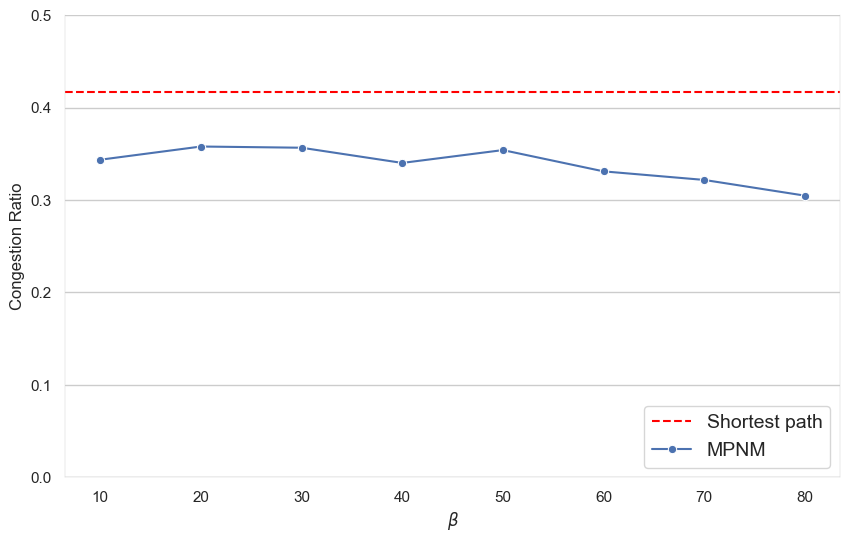

In [28]:
# Separate data for alpha_2=0, 0, 100 and other values
df_60s_ref = df_60s[df_60s['alpha_2'] == 0]
df_60s_other = df_60s[df_60s['alpha_2'] != 0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal reference line for alpha (0, 0, 100)
plt.axhline(y=df_60s_ref['Congestion_ratio_AVG'].iloc[0], color='red', linestyle='--', label='Shortest path')

# Plotting other alpha values
sns.lineplot(x='alpha_2', y='Congestion_ratio_AVG', data=df_60s_other, marker='o', linestyle='-', label='MPNM', ax=ax)

# Adding labels and title
plt.xlabel(r"$\beta$")
plt.ylabel('Congestion Ratio')
# scaling y-axis by 0.1
plt.yticks(np.arange(0, 0.6, 0.1))

# plt.title('Average of Congestion Ratio for 60 YTs')
# plt.ylim(0.3, 0.45)
# # y축 단위값 0.03
# plt.yticks(np.arange(0.3, 0.45, 0.03))

# Adding grid and legend
plt.grid(True)
plt.legend(fontsize=14, loc='lower right')

# Setting spine widths
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0.3)
ax.spines['left'].set_linewidth(0.3)
ax.xaxis.grid(False)

# Display the plot
plt.show()


c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


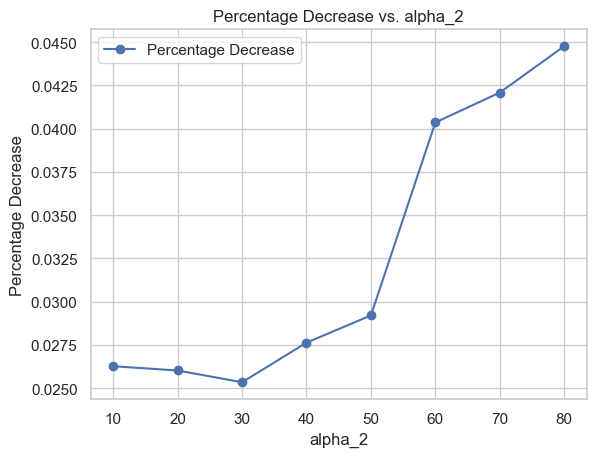

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Your DataFrame
df = df_40s.copy()

# Filter out rows with alpha_1=0, alpha_2=0, alpha_3=100
df_filtered = df[(df['alpha_1'] != 0) | (df['alpha_2'] != 0) | (df['alpha_3'] != 100)]

# Extract reference Congestion_ratio_AVG for alpha_1=0, alpha_2=0, alpha_3=100
reference_congestion = df.loc[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100), 'Congestion_ratio_AVG'].values[0]

# Calculate Percentage Decrease for each row
df_filtered['Percentage_Decrease'] = (reference_congestion - df_filtered['Congestion_ratio_AVG'])

# Plotting the Percentage Decrease based on alpha_2 values
plt.plot(df_filtered['alpha_2'], df_filtered['Percentage_Decrease'], marker='o', linestyle='-', label='Percentage Decrease')

# Adding labels and title
plt.xlabel('alpha_2')
plt.ylabel('Percentage Decrease')


plt.title('Percentage Decrease vs. alpha_2')


# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


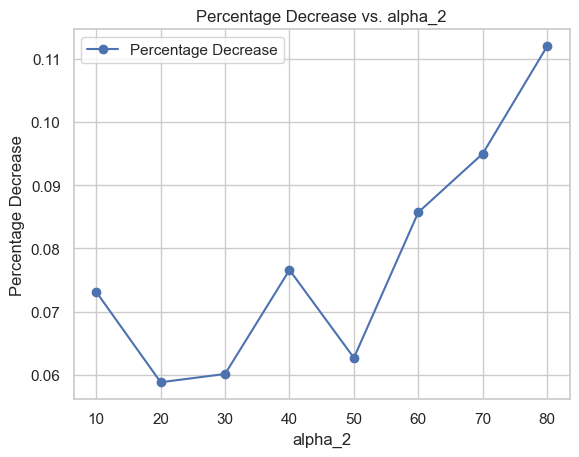

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Your DataFrame
df = df_60s.copy()

# Filter out rows with alpha_1=0, alpha_2=0, alpha_3=100
df_filtered = df[(df['alpha_1'] != 0) | (df['alpha_2'] != 0) | (df['alpha_3'] != 100)]

# Extract reference Congestion_ratio_AVG for alpha_1=0, alpha_2=0, alpha_3=100
reference_congestion = df.loc[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100), 'Congestion_ratio_AVG'].values[0]

# Calculate Percentage Decrease for each row
df_filtered['Percentage_Decrease'] = (reference_congestion - df_filtered['Congestion_ratio_AVG'])

# Plotting the Percentage Decrease based on alpha_2 values
plt.plot(df_filtered['alpha_2'], df_filtered['Percentage_Decrease'], marker='o', linestyle='-', label='Percentage Decrease')

# Adding labels and title
plt.xlabel('alpha_2')
plt.ylabel('Percentage Decrease')


plt.title('Percentage Decrease vs. alpha_2')


# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


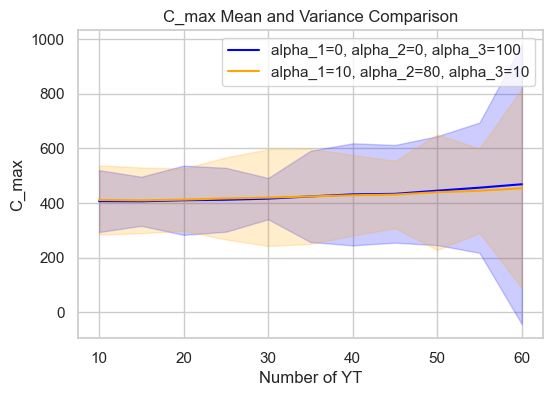

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = all_alpha_df.copy()

# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 C_max의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].mean()

# Number of YT별 C_max의 분산 계산
var_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].var()
var_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].var()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 분산에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, mean_alpha_1 - var_alpha_1, mean_alpha_1 + var_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, mean_alpha_2 - var_alpha_2, mean_alpha_2 + var_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('C_max Mean and Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

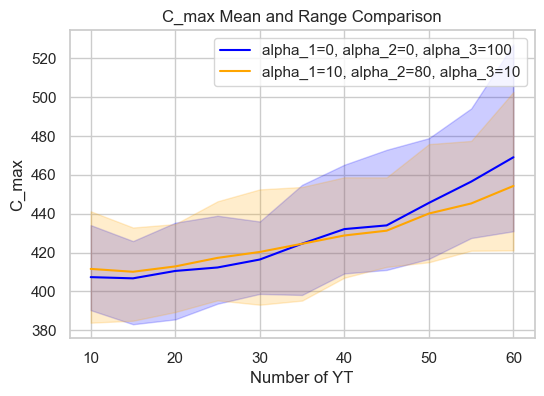

In [32]:
# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 C_max의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].mean()

# Number of YT별 C_max의 최대, 최소값 계산
min_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].min()
max_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].max()

min_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].min()
max_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].max()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 실제 값의 범위에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, min_alpha_1, max_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, min_alpha_2, max_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('C_max Mean and Range Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

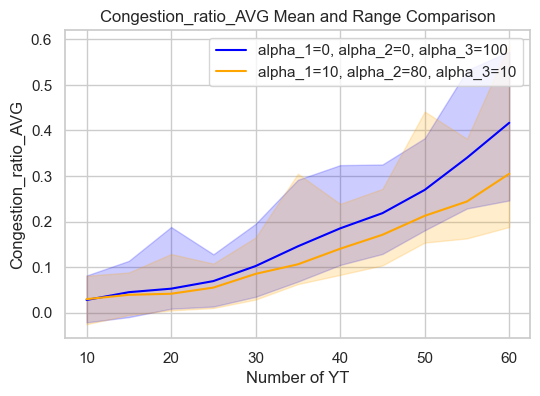

In [33]:
# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 Congestion_ratio_AVG의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].mean()

# Congestion_ratio_AVG의 최대, 최소값 계산
min_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].min()
max_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].max()

min_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].min()
max_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].max()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 실제 값의 범위에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, min_alpha_1, max_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, min_alpha_2, max_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('Congestion_ratio_AVG Mean and Range Comparison')
plt.xlabel('Number of YT')
plt.ylabel('Congestion_ratio_AVG')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

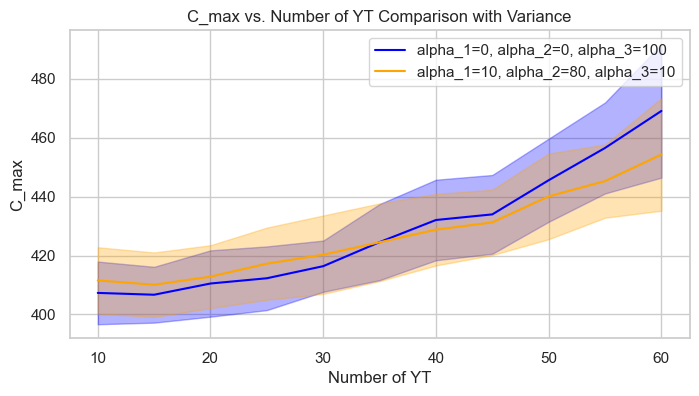

In [34]:

# alpha_1이 0, alpha_2가 0, alpha_3이 100인 행 추출
filtered_data_1 = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]

# alpha_1이 10, alpha_2가 80, alpha_3이 10인 행 추출
filtered_data_2 = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# 각각의 데이터에 대해 Number of YT 별로 C_max의 평균 및 분산 계산
grouped_data_1 = filtered_data_1.groupby('Number of YT')['C_max'].agg(['mean', 'std']).reset_index()
grouped_data_2 = filtered_data_2.groupby('Number of YT')['C_max'].agg(['mean', 'std']).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 4))

# 꺾은선 그래프 및 그림자 처리
plt.plot(grouped_data_1['Number of YT'], grouped_data_1['mean'], label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
plt.fill_between(
    grouped_data_1['Number of YT'],
    grouped_data_1['mean'] - grouped_data_1['std'],
    grouped_data_1['mean'] + grouped_data_1['std'],
    color='blue',
    alpha=0.3
)

plt.plot(grouped_data_2['Number of YT'], grouped_data_2['mean'], label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')
plt.fill_between(
    grouped_data_2['Number of YT'],
    grouped_data_2['mean'] - grouped_data_2['std'],
    grouped_data_2['mean'] + grouped_data_2['std'],
    color='orange',
    alpha=0.3
)

# 그래프 제목 및 레이블 설정
plt.title('C_max vs. Number of YT Comparison with Variance')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


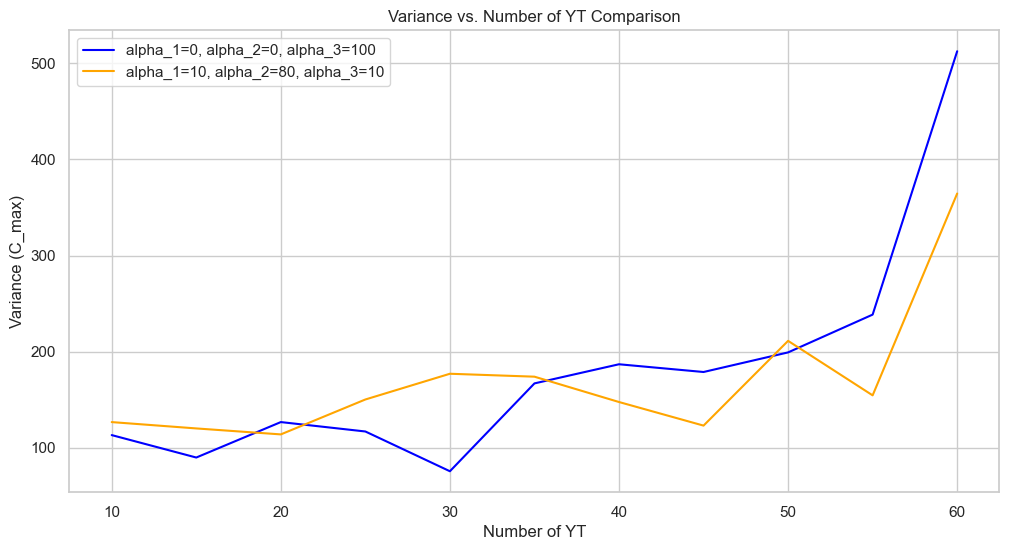

In [35]:
# 두 데이터셋에 대해 Number of YT에 따른 분산 계산
variance_data_1 = filtered_data_1.groupby('Number of YT')['C_max'].var().reset_index()
variance_data_2 = filtered_data_2.groupby('Number of YT')['C_max'].var().reset_index()

# 그래프 그리기
plt.figure(figsize=(12, 6))

plt.plot(variance_data_1['Number of YT'], variance_data_1['C_max'], label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
plt.plot(variance_data_2['Number of YT'], variance_data_2['C_max'], label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 그래프 제목 및 레이블 설정
plt.title('Variance vs. Number of YT Comparison')
plt.xlabel('Number of YT')
plt.ylabel('Variance (C_max)')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


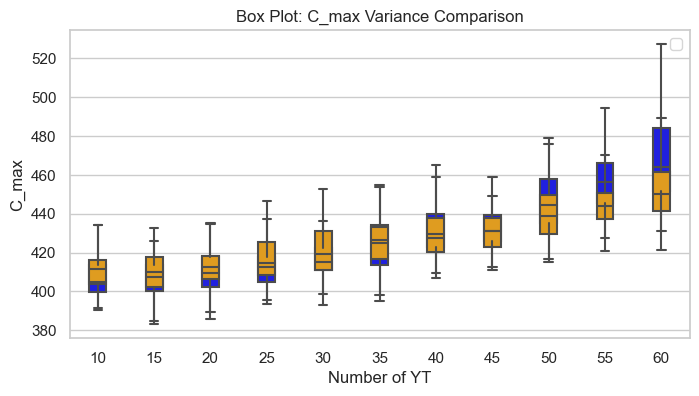

In [36]:
# 그래프 그리기
plt.figure(figsize=(8, 4))

sns.boxplot(x='Number of YT', y='C_max', data=filtered_data_1, color='blue', width=0.3,dodge=True, showfliers=False)
sns.boxplot(x='Number of YT', y='C_max', data=filtered_data_2, color='orange', width=0.3,dodge=True ,showfliers=False)

# 그래프 제목 및 레이블 설정
plt.title('Box Plot: C_max Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

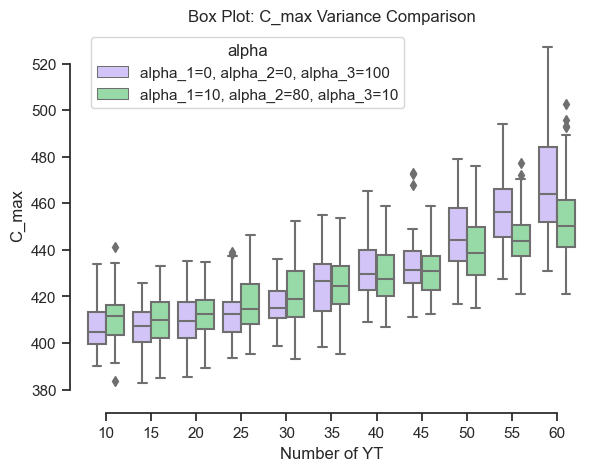

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임이 tips 대신 filtered_data_1과 filtered_data_2를 사용
sns.set_theme(style="ticks", palette="pastel")

# Combine the two datasets for visualization
combined_data = pd.concat([filtered_data_1.assign(alpha='alpha_1=0, alpha_2=0, alpha_3=100'), 
                           filtered_data_2.assign(alpha='alpha_1=10, alpha_2=80, alpha_3=10')])

# Draw a nested boxplot to show C_max by Number of YT and alpha
sns.boxplot(x="Number of YT", y="C_max",
            hue="alpha", palette=["m", "g"],
            data=combined_data)
sns.despine(offset=10, trim=True)

# Set the title and labels
plt.title('Box Plot: C_max Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# Show the plot
plt.show()


#
alpha = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
         [0, 80, 70, 60, 50, 40, 30, 20, 10],
         [100, 10, 10, 10, 10, 10, 10, 10, 10]]


In [38]:
# 'Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'가 같은 행끼리 묶은 뒤, 'C_max'의 표준편차 계산
std_dev_by_group = all_alpha_df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max'].std().reset_index()

# C_max를 C_max의 표준편차로 열 이름 변경
std_dev_by_group.rename(columns={'C_max': 'C_max_std'}, inplace=True)

# 결과 출력
std_dev_by_group

,Number of YT,alpha_1,alpha_2,alpha_3,C_max_std
0,10,0,0,100,10.640166
1,10,10,80,10,11.257528
2,10,20,70,10,8.194852
3,10,30,60,10,10.545705
4,10,40,50,10,10.937548
...,...,...,...,...,...
94,60,40,50,10,14.319800
95,60,50,40,10,12.777979
96,60,60,30,10,22.412262
97,60,70,20,10,20.236408


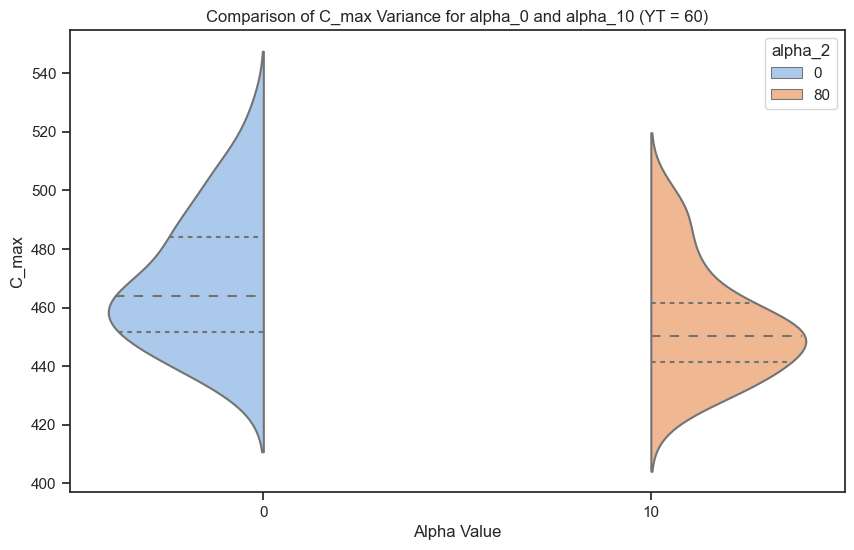

In [39]:
# 알파값이 0, 0, 100과 10, 80, 10인 경우의 데이터 추출
alpha_0_data = all_alpha_df[(all_alpha_df['alpha_1'] == 0) & (all_alpha_df['alpha_2'] == 0) & (all_alpha_df['alpha_3'] == 100) & (all_alpha_df['Number of YT'] == 60)]
alpha_10_data = all_alpha_df[(all_alpha_df['alpha_1'] == 10) & (all_alpha_df['alpha_2'] == 80) & (all_alpha_df['alpha_3'] == 10) & (all_alpha_df['Number of YT'] == 60)]

# 바이올린 플롯 그리기
plt.figure(figsize=(10, 6))
sns.violinplot(x='alpha_1', y='C_max', data=pd.concat([alpha_0_data, alpha_10_data]), hue='alpha_2', split=True, inner='quartile')
plt.title('Comparison of C_max Variance for alpha_0 and alpha_10 (YT = 60)')
plt.xlabel('Alpha Value')
plt.ylabel('C_max')
plt.show()

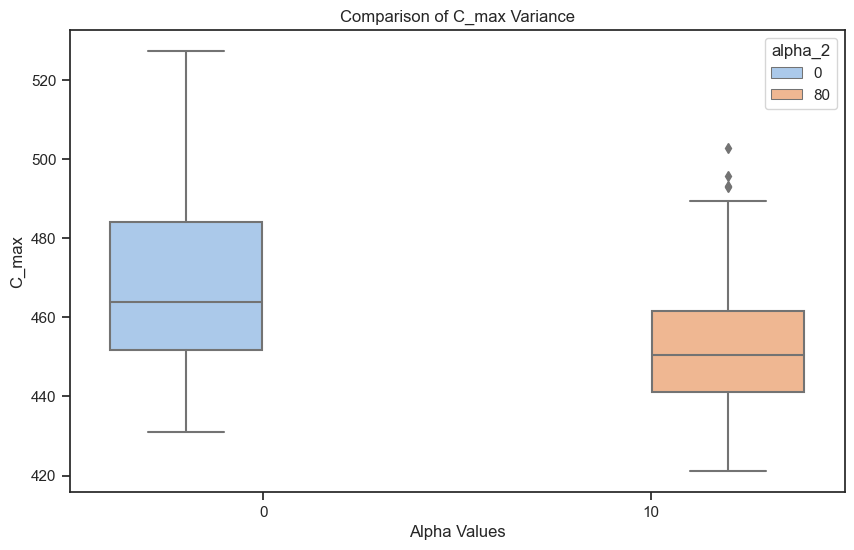

In [40]:
# 알파값이 0, 0, 100인 행과 10, 80, 10이면서 YT수가 60대인 행만 선택
selected_data = all_alpha_df[(all_alpha_df['alpha_1'] == 0) & (all_alpha_df['alpha_2'] == 0) & (all_alpha_df['alpha_3'] == 100) & (all_alpha_df['Number of YT'] == 60) |
                             ((all_alpha_df['alpha_1'] == 10) & (all_alpha_df['alpha_2'] == 80) & (all_alpha_df['alpha_3'] == 10) & (all_alpha_df['Number of YT'] == 60))]

# 상자 그림 생성
plt.figure(figsize=(10, 6))
sns.boxplot(x='alpha_1', y='C_max', hue='alpha_2', data=selected_data)
plt.title('Comparison of C_max Variance')
plt.xlabel('Alpha Values')
plt.ylabel('C_max')
plt.show()

c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


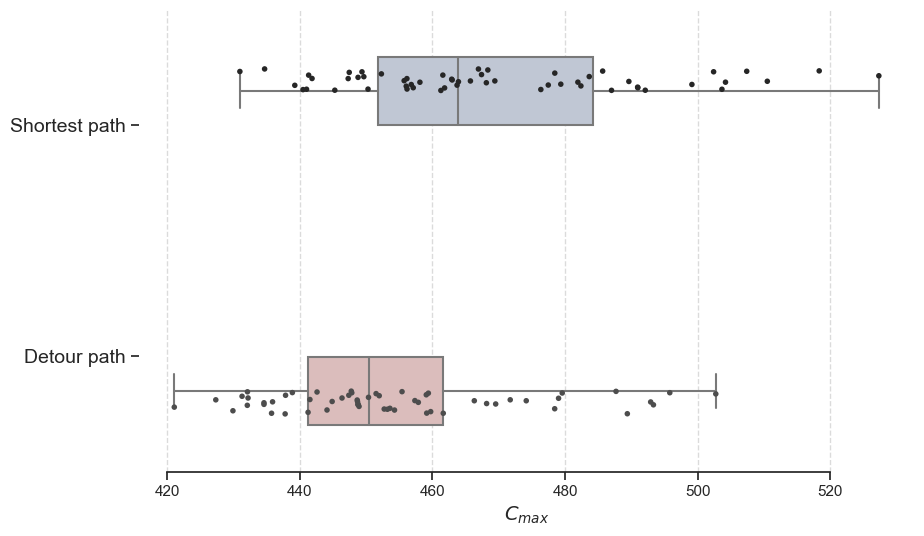

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select rows where alpha values match the conditions
selected_data = all_alpha_df[
    ((all_alpha_df['alpha_1'] == 0) & (all_alpha_df['alpha_2'] == 0) & (all_alpha_df['alpha_3'] == 100) & (all_alpha_df['Number of YT'] == 60)) |
    ((all_alpha_df['alpha_1'] == 10) & (all_alpha_df['alpha_2'] == 80) & (all_alpha_df['alpha_3'] == 10) & (all_alpha_df['Number of YT'] == 60))
]


# Map numeric x-axis ticks to labels
alpha_labels = {0: 'Shortest path', 10: 'Detour path'}
selected_data['alpha_1_labels'] = selected_data['alpha_1'].map(alpha_labels)

# Set the plot style
sns.set_theme(style="ticks")

# Create a horizontal boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y='alpha_1_labels', x='C_max', hue='alpha_2', data=selected_data, dodge=True, palette="vlag", width=0.6, whis=[0, 100])

# Add in points to show each observation
sns.stripplot(y='alpha_1_labels', x='C_max', hue='alpha_2', data=selected_data, dodge=True, size=4, color=".3")

# Tweak the visual presentation
# plt.title('Comparison of C_max Variance')
plt.xlabel('$C_{max}$', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(trim=True, left=True)

# Remove y-axis label
plt.ylabel('')
# Remove legend
plt.legend().set_visible(False)

# Show the plot
plt.show()

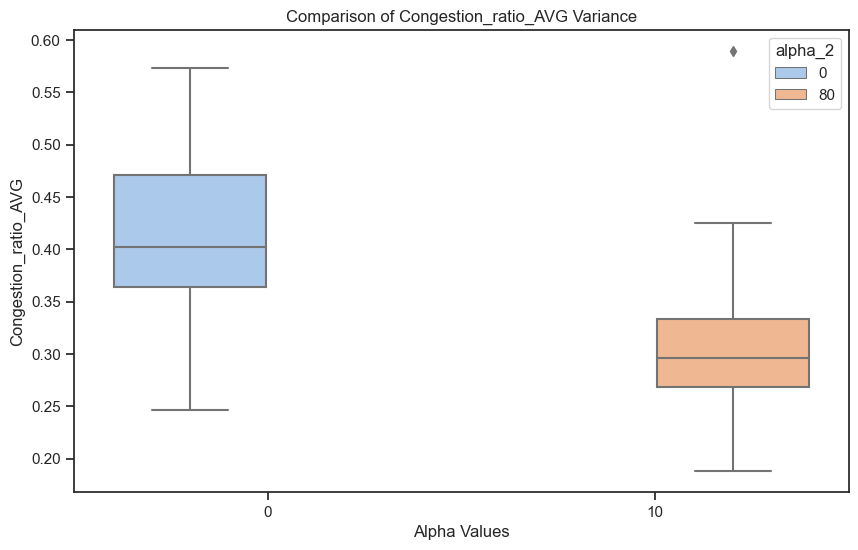

In [43]:
# 알파값이 0, 0, 100인 행과 10, 80, 10이면서 YT수가 60대인 행만 선택
selected_data = all_alpha_df[(all_alpha_df['alpha_1'] == 0) & (all_alpha_df['alpha_2'] == 0) & (all_alpha_df['alpha_3'] == 100) & (all_alpha_df['Number of YT'] == 60) |
                             ((all_alpha_df['alpha_1'] == 10) & (all_alpha_df['alpha_2'] == 80) & (all_alpha_df['alpha_3'] == 10) & (all_alpha_df['Number of YT'] == 60))]

# 상자 그림 생성
plt.figure(figsize=(10, 6))
sns.boxplot(x='alpha_1', y='Congestion_ratio_AVG', hue='alpha_2', data=selected_data)
plt.title('Comparison of Congestion_ratio_AVG Variance')
plt.xlabel('Alpha Values')
plt.ylabel('Congestion_ratio_AVG')
plt.show()


In [32]:
# gamma combination visualization
folder_path = 'gamma_combination'
y_col = ['C_max_prev', 'C_max_now', 'C_max', 'Congestion_ratio_AVG', 'Congestion_ratio_AVG_prev', 'Congestion_ratio_AVG_now']

original_df = f.get_dfs_by_folder(folder_path, y_col, True, standard_outlier = y_col[2])

original_df = f.to_numeric(original_df, y_col[0])
original_df = f.to_numeric(original_df, y_col[1])
original_df = f.to_numeric(original_df, y_col[3])
original_df_30s = f.to_numeric(original_df, y_col[4])
original_df = f.to_numeric(original_df, y_col[5])

for file_name, df in original_df:
    # add column
    df['Number of YT'] = int(df['Prev Truck Number'].unique()[0]) + int(df['Now Truck Number'].unique()[0])

gamma_combination = pd.DataFrame()

# original_df에 있는 모든 파일을 합쳐 하나의 df로 만들기
for file_name, df in original_df:
    gamma_combination = pd.concat([gamma_combination, df], ignore_index=True)

gamma_combination

Remove outliers by  C_max !


,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,repeat_num,C_max_prev,C_max_now,C_max,Congestion_ratio_AVG,Congestion_ratio_AVG_prev,Congestion_ratio_AVG_now,Number of YT
0,20,20,10,10,80,1,394.464,413.600,413.600,0.164961,0.199316,0.130607,40
1,20,20,10,10,80,3,404.344,407.904,407.904,0.147567,0.122145,0.172990,40
2,20,20,10,10,80,4,424.512,411.184,424.512,0.126024,0.158710,0.093338,40
3,20,20,10,10,80,5,415.904,405.472,415.904,0.106360,0.076439,0.136282,40
4,20,20,10,10,80,6,414.768,439.832,439.832,0.204095,0.229262,0.178927,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,30,30,40,30,30,31,424.888,445.568,445.568,0.349557,0.403585,0.295529,60
967,30,30,40,30,30,32,437.528,444.200,444.200,0.329697,0.349799,0.309595,60
968,30,30,40,30,30,33,465.032,494.720,494.720,0.437508,0.554698,0.320319,60
969,30,30,40,30,30,34,458.808,456.440,458.808,0.426642,0.467210,0.386074,60


In [33]:
df  = gamma_combination.copy()

# 'Number of YT'에 따라 데이터 분리하고, 'alpha_1', 'alpha_2', 'alpha_3'의 값이 같은 행끼리 묶은 뒤, 'Congestion_ratio_AVG'의 평균 계산
congestion_ratio_avg_gamma_combination = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['Congestion_ratio_AVG'].mean().reset_index()
C_max_avg_gamma_combination = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max'].mean().reset_index()
C_max_prev_avg_gamma_combination = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max_prev'].mean().reset_index()
C_max_now_avg_gamma_combination = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['C_max_now'].mean().reset_index()

C_max_avg_gamma_combination



,Number of YT,alpha_1,alpha_2,alpha_3,C_max
0,40,10,10,80,431.288485
1,40,10,20,70,432.374750
2,40,20,20,60,432.146750
3,40,20,30,50,429.122839
4,40,30,30,40,432.595250
5,40,40,30,30,430.479030
6,45,10,10,80,435.463294
7,45,10,20,70,437.108364
8,45,20,20,60,434.524645
9,45,20,30,50,432.823742


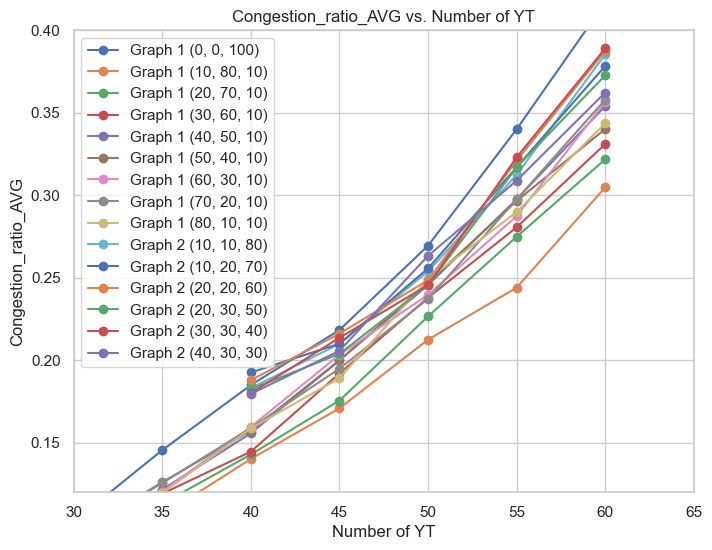

In [34]:
# 특정 알파값에 따라 데이터 추출 및 그래프 그리기
alpha_values_1 = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
                [0, 80, 70, 60, 50, 40, 30, 20, 10],
                [100, 10, 10, 10, 10, 10, 10, 10, 10]]

alpha_values_2 = [[10, 10, 20, 20, 30, 40],
                [10, 20, 20, 30, 30, 30],
                [80, 70, 60, 50, 40, 30]]

# 전체 그래프를 그리기 위한 설정
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# 각 알파값에 따라 데이터를 추출하고 그래프 그리기
for i in range(len(alpha_values_1[0])):
    df = congestion_ratio_avg.copy()
    df_1 = df[(df['alpha_1'] == alpha_values_1[0][i]) & (df['alpha_2'] == alpha_values_1[1][i]) & (df['alpha_3'] == alpha_values_1[2][i])]
    
    # 꺾은선 그래프 그리기
    plt.plot(df_1['Number of YT'], df_1['Congestion_ratio_AVG'], marker='o', linestyle='-', label=f'Graph 1 ({alpha_values_1[0][i]}, {alpha_values_1[1][i]}, {alpha_values_1[2][i]})')

for i in range(len(alpha_values_2[0])):
    df = congestion_ratio_avg_gamma_combination.copy()
    df_2 = df[(df['alpha_1'] == alpha_values_2[0][i]) & (df['alpha_2'] == alpha_values_2[1][i]) & (df['alpha_3'] == alpha_values_2[2][i])]
    
    # 꺾은선 그래프 그리기
    plt.plot(df_2['Number of YT'], df_2['Congestion_ratio_AVG'], marker='o', linestyle='-', label=f'Graph 2 ({alpha_values_2[0][i]}, {alpha_values_2[1][i]}, {alpha_values_2[2][i]})')

# 그래프에 레이블 추가
plt.xlabel('Number of YT')
plt.ylabel('Congestion_ratio_AVG')
plt.title('Congestion_ratio_AVG vs. Number of YT')
plt.xlim(30,65)
plt.ylim(0.12,0.4)
# 그리드 추가
plt.grid(True)

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()


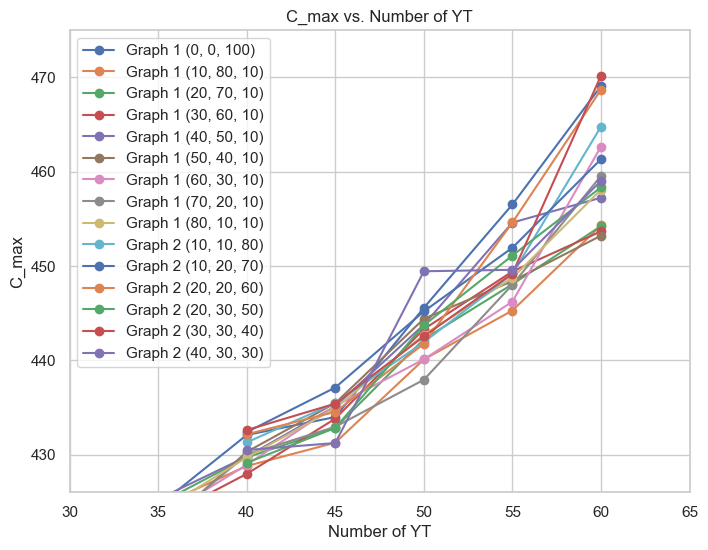

In [35]:
# 특정 알파값에 따라 데이터 추출 및 그래프 그리기
alpha_values_1 = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
                [0, 80, 70, 60, 50, 40, 30, 20, 10],
                [100, 10, 10, 10, 10, 10, 10, 10, 10]]

alpha_values_2 = [[10, 10, 20, 20, 30, 40],
                [10, 20, 20, 30, 30, 30],
                [80, 70, 60, 50, 40, 30]]

# 전체 그래프를 그리기 위한 설정
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# 각 알파값에 따라 데이터를 추출하고 그래프 그리기
for i in range(len(alpha_values_1[0])):
    df = C_max_avg.copy()
    df_1 = df[(df['alpha_1'] == alpha_values_1[0][i]) & (df['alpha_2'] == alpha_values_1[1][i]) & (df['alpha_3'] == alpha_values_1[2][i])]
    
    # 꺾은선 그래프 그리기
    plt.plot(df_1['Number of YT'], df_1['C_max'], marker='o', linestyle='-', label=f'Graph 1 ({alpha_values_1[0][i]}, {alpha_values_1[1][i]}, {alpha_values_1[2][i]})')

for i in range(len(alpha_values_2[0])):
    df = C_max_avg_gamma_combination.copy()
    df_2 = df[(df['alpha_1'] == alpha_values_2[0][i]) & (df['alpha_2'] == alpha_values_2[1][i]) & (df['alpha_3'] == alpha_values_2[2][i])]
    
    # 꺾은선 그래프 그리기
    plt.plot(df_2['Number of YT'], df_2['C_max'], marker='o', linestyle='-', label=f'Graph 2 ({alpha_values_2[0][i]}, {alpha_values_2[1][i]}, {alpha_values_2[2][i]})')

# 그래프에 레이블 추가
plt.xlabel('Number of YT')
plt.ylabel('C_max')
plt.title('C_max vs. Number of YT')
plt.xlim(30,65)
# plt.ylim(0.1,0.2)
plt.ylim(426, 475)
# 그리드 추가
plt.grid(True)

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()
